In [1]:
import datetime

# Third-party
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import astropy.time as at
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import astroplan
from astroplan import Observer, FixedTarget
from astropy.time import Time


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]

>>> from astroplan import download_IERS_A
>>> download_IERS_A()



In [3]:
mdm = Observer.at_site("MDM", timezone="America/Phoenix")
t1 = Time(datetime.datetime(2015, 10, 14, 18, 0))
t2 = t1 + 12*u.hour
time_range = Time([t1, t2])

In [4]:
def coords_in_rect(c, corner_c):
    if not c.frame.is_equivalent_frame(corner_c[0].frame):
        raise ValueError("Frame mismatch.")
    
    min_lon = corner_c[0].spherical.lon
    min_lat = corner_c[0].spherical.lat
    max_lon = corner_c[1].spherical.lon
    max_lat = corner_c[1].spherical.lat
    
    return ((c.spherical.lon > min_lon) & (c.spherical.lon < max_lon) & 
            (c.spherical.lat > min_lat) & (c.spherical.lat < max_lat)) 

---

## How many GASS targets are there?

In [5]:
css = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/catalina.csv")
print(css.colnames)

['ID', 'ra', 'dec', 'VmagAvg', 'helio_dist', 'l', 'b', 'mjd0', 'amp', 'period']


In [6]:
linear = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/linear.csv")
print(linear.colnames)

['ra', 'dec', 'ID', 'period', 'not_hjd0', 'amp', 'rmagAvg', 'helio_dist', 'l', 'b']


In [7]:
css_c = coord.SkyCoord(ra=css['ra']*u.deg, dec=css['dec']*u.deg, distance=css['helio_dist']*u.kpc)
lin_c = coord.SkyCoord(ra=linear['ra']*u.deg, dec=linear['dec']*u.deg, distance=linear['helio_dist']*u.kpc)

### Filter by window on sky

In [8]:
window_corners = [coord.SkyCoord(l=100*u.deg, b=-20*u.deg,frame='galactic'), 
                  coord.SkyCoord(l=220*u.deg, b=-10*u.deg,frame='galactic')]
css_ix = coords_in_rect(css_c.galactic, window_corners)
lin_ix = coords_in_rect(lin_c.galactic, window_corners)
print("{} CSS targets, {} LINEAR targets in this window.".format(css_ix.sum(), lin_ix.sum()))

162 CSS targets, 0 LINEAR targets in this window.


In [9]:
gass_tbl = css[css_ix]
gass = coord.SkyCoord(l=gass_tbl['l']*u.deg, b=gass_tbl['b']*u.deg, 
                      distance=gass_tbl['helio_dist']*u.kpc, frame='galactic')

### Filter by distance

In [10]:
ix = (gass.distance > 2.5*u.kpc) & (gass.distance < 8.*u.kpc)
gass = gass[ix]
gass_tbl = gass_tbl[ix]

In [11]:
print("{} GASS targets".format(len(gass)))

54 GASS targets


(-20, -10)

/Users/adrian/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


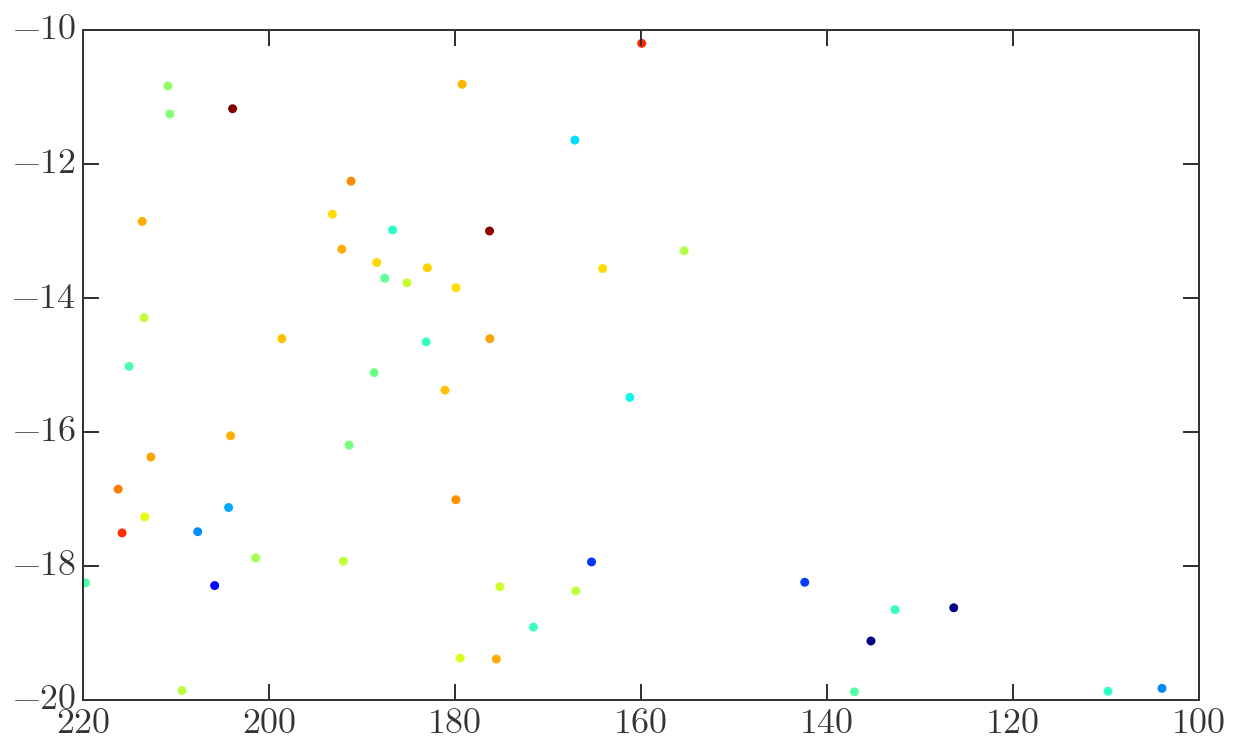

In [12]:
pl.figure(figsize=(10,6))
pl.scatter(gass.l.degree, gass.b.degree, c=gass_tbl['VmagAvg'], marker='o')
pl.xlim(220,100)
pl.ylim(-20,-10)

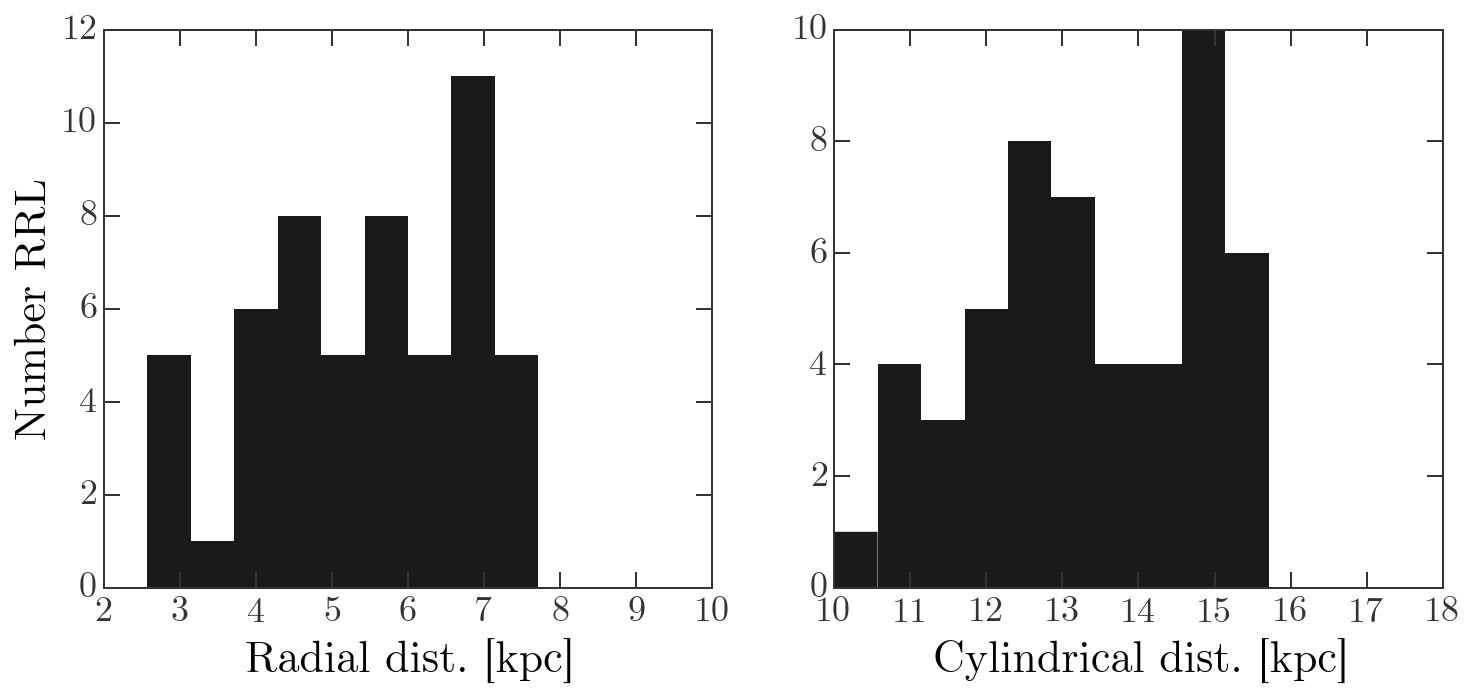

In [13]:
fig,axes = pl.subplots(1,2,figsize=(12,5))
n,bins,pa = axes[0].hist(gass.distance, bins=np.linspace(2,10,15))
axes[0].set_xlabel("Radial dist. [kpc]")
axes[0].set_xlim(bins.min(), bins.max())

n,bins,pa = axes[1].hist(gass.galactocentric.represent_as(coord.CylindricalRepresentation).rho, bins=bins+8)
axes[1].set_xlabel("Cylindrical dist. [kpc]")
axes[1].set_xlim(bins.min(), bins.max())

axes[0].set_ylabel("Number RRL")

### Red circle below is brightness limit of Catalina

<matplotlib.colorbar.Colorbar instance at 0x10e9f4320>

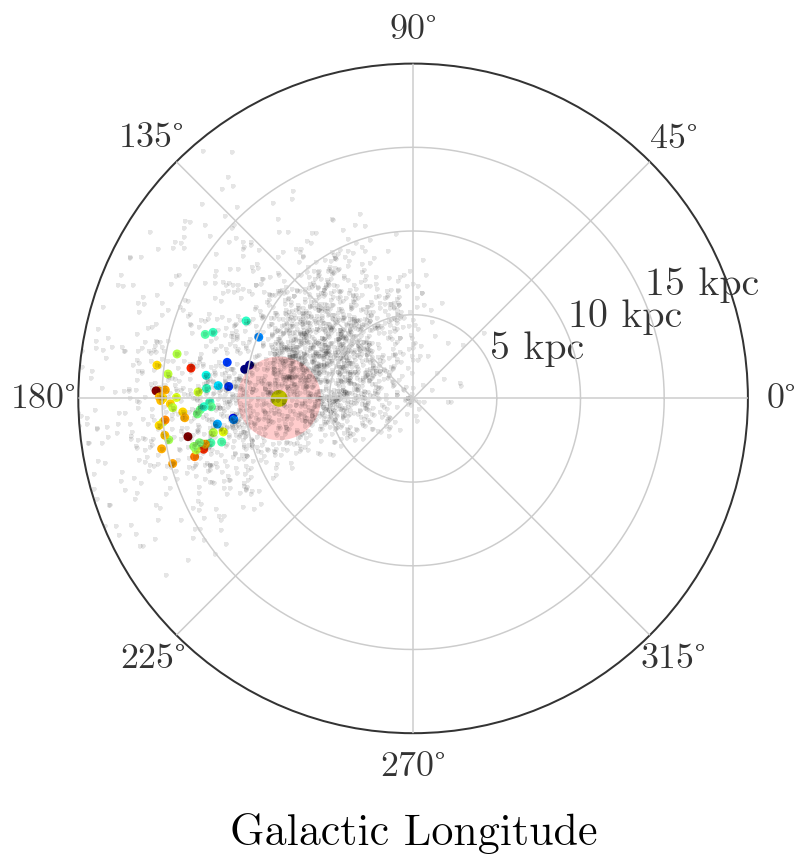

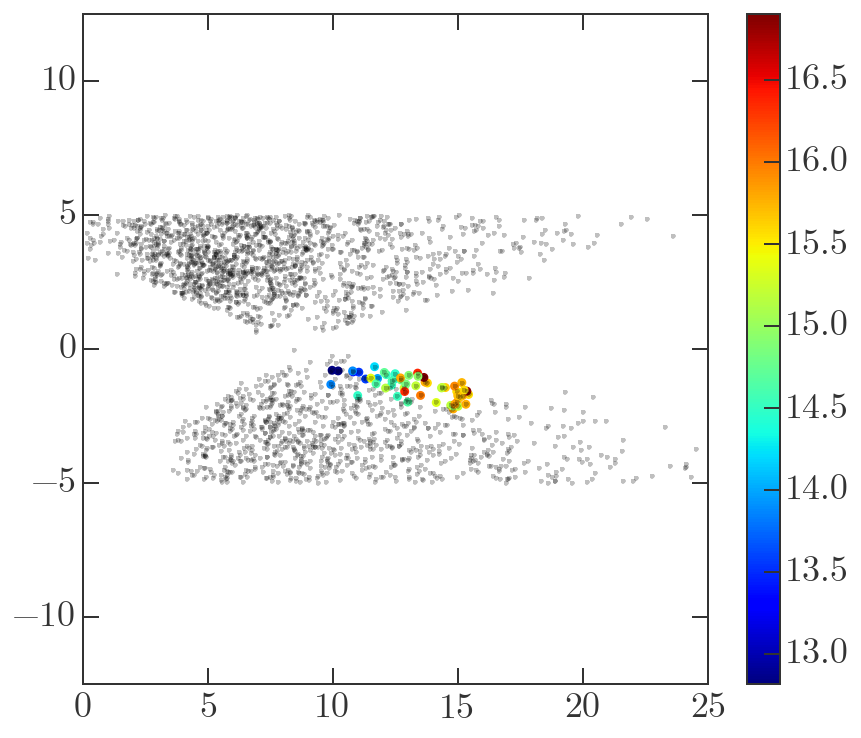

In [14]:
fig,ax = pl.subplots(1,1,figsize=(6,6),subplot_kw =dict(polar=True))

ax.add_artist(mpl.patches.Circle((-8.,0), radius=2.5, transform=ax.transData._b, facecolor='r', alpha=0.2))
ax.add_artist(mpl.patches.Circle((-8.,0), radius=0.5, transform=ax.transData._b, facecolor='y', alpha=1.))

gass_cyl = gass.galactocentric.represent_as(coord.CylindricalRepresentation)
css_cyl = css_c.galactocentric.represent_as(coord.CylindricalRepresentation)

ax.plot(css_cyl.phi.to(u.radian)[np.abs(css_cyl.z) < 5*u.kpc], 
        css_cyl.rho.to(u.kpc)[np.abs(css_cyl.z) < 5*u.kpc], 
        color='k', linestyle='none', marker='.', alpha=0.1)
# ax.plot(gass_cyl.phi.to(u.radian), gass_cyl.rho.to(u.kpc), 
#         color='k', linestyle='none', marker='o')
ax.scatter(gass_cyl.phi.to(u.radian), gass_cyl.rho.to(u.kpc), 
           c=gass_tbl['VmagAvg'], marker='o')

ax.set_rmax(20.0)
ax.grid(True)

ticks = [5,10,15]
ax.set_rticks(ticks)
ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
ax.set_xlabel("Galactic Longitude", labelpad=15)
ax.tick_params(axis='y', labelsize=20)
# fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

# ------
fig,ax = pl.subplots(1,1,figsize=(7,6))

gass_cyl = gass.galactocentric.represent_as(coord.CylindricalRepresentation)
css_cyl = css_c.galactocentric.represent_as(coord.CylindricalRepresentation)

ax.plot(css_cyl.rho.to(u.kpc)[np.abs(css_cyl.z) < 5*u.kpc], 
        css_cyl.z.to(u.kpc)[np.abs(css_cyl.z) < 5*u.kpc], 
        color='k', linestyle='none', marker='.', alpha=0.25)
cc = ax.scatter(gass_cyl.rho.to(u.kpc), 
                gass_cyl.z.to(u.kpc), 
                c=gass_tbl['VmagAvg'], marker='o')
ax.set_xlim(0,25)
ax.set_ylim(-12.5,12.5)
fig.colorbar(cc)

# ticks = [10,20]
# ax.set_rticks(ticks)
# ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
# ax.set_xlabel("Galactic Longitude", labelpad=15)
# ax.tick_params(axis='y', labelsize=20)
# # fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

(array([  2.,   3.,   3.,   2.,  11.,   9.,   8.,  12.,   2.,   2.]),
 array([ 12.82 ,  13.228,  13.636,  14.044,  14.452,  14.86 ,  15.268,
         15.676,  16.084,  16.492,  16.9  ]),
 <a list of 10 Patch objects>)

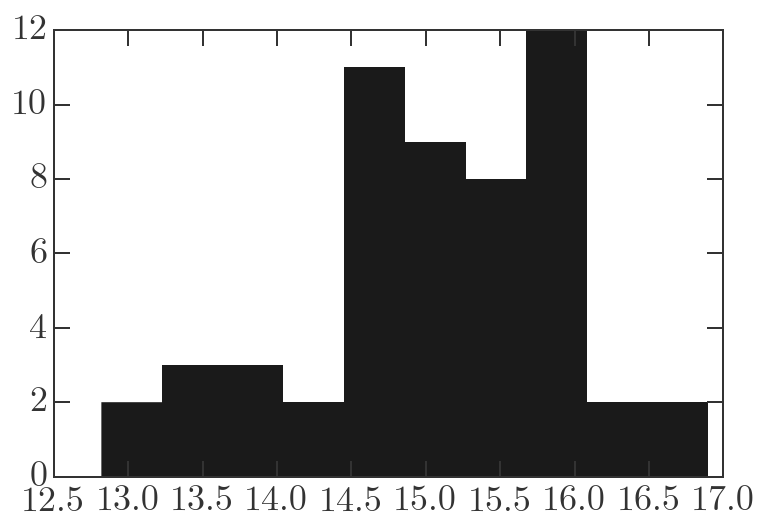

In [15]:
pl.hist(gass_tbl['VmagAvg'])

In [16]:
gass_tbl['ID2015'] = ["GASS2015RR{0:d}".format(x+1) for x in np.arange(len(gass_tbl)).astype(int)]

In [33]:
# ascii.write(gass_tbl, "/Users/adrian/projects/triand-rrlyrae/data/targets/gass.txt")

In [52]:
# ascii.write(gass_tbl[['ID2015','ra','dec']], "/Users/adrian/projects/triand-rrlyrae/data/targets/gass_targets_2015_short.txt")#, format="ascii")

In [17]:
gass_tbl_sex = gass_tbl.copy()

ra = coord.Longitude(gass_tbl_sex['ra']*u.deg)
gass_tbl_sex['ra_sex'] = ra.to_string(unit=u.hour, precision=5, sep=' ')

dec = coord.Latitude(gass_tbl_sex['dec']*u.deg)
gass_tbl_sex['dec_sex'] = dec.to_string(unit=u.degree, precision=5, sep=' ')

ascii.write(gass_tbl_sex[['ID2015','ra_sex','dec_sex']], "/Users/adrian/projects/triand-rrlyrae/data/targets/gass_targets_2015_short_sexa.txt")

---

## Re-doing TriAnd selection

In [18]:
window_corners = [coord.SkyCoord(l=100*u.deg, b=-35*u.deg,frame='galactic'), 
                  coord.SkyCoord(l=160*u.deg, b=-15*u.deg,frame='galactic')]
css_ix2 = coords_in_rect(css_c.galactic, window_corners)
print("{} CSS targets in this window.".format(css_ix2.sum()))

340 CSS targets in this window.


In [19]:
triand_tbl = css[css_ix2]
triand = coord.SkyCoord(l=triand_tbl['l']*u.deg, b=triand_tbl['b']*u.deg, 
                        distance=triand_tbl['helio_dist']*u.kpc, frame='galactic')

### Filter distance

In [20]:
ix = (triand.distance > 15*u.kpc) & (triand.distance < 21*u.kpc)
triand = triand[ix]
triand_tbl = triand_tbl[ix]

In [21]:
print("{} TriAnd targets".format(len(triand)))

77 TriAnd targets


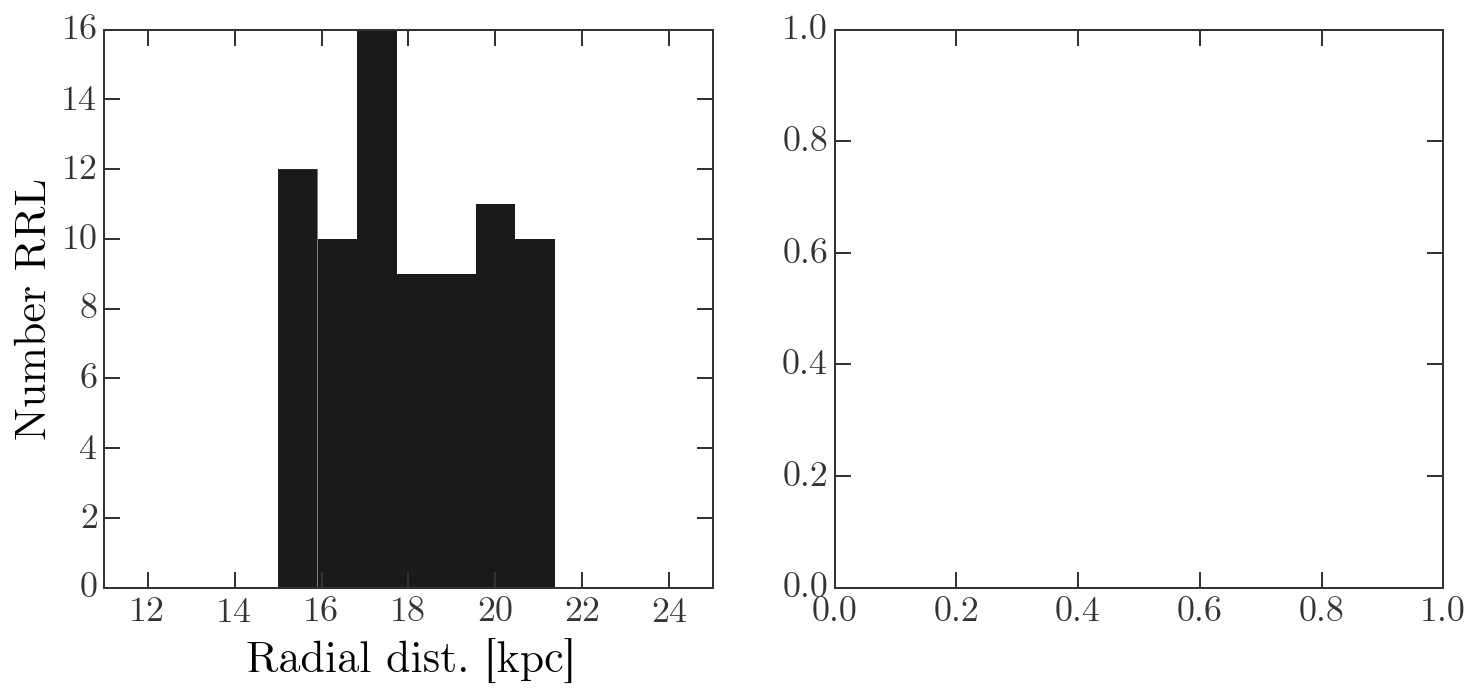

In [22]:
fig,axes = pl.subplots(1,2,figsize=(12,5))
axes[0].hist(triand_tbl['helio_dist'], bins=np.linspace(15,25,12))
axes[0].set_xlabel("Radial dist. [kpc]")
axes[0].set_xlim(11,25)

# axes[1].hist(gc_cyl_triand.rho, bins=8)
# axes[1].set_xlabel("Cylindrical dist. [kpc]")
# axes[1].set_xlim(17,24)

axes[0].set_ylabel("Number RRL")

In [23]:
# fig,ax = pl.subplots(1,1,figsize=(8,8),subplot_kw =dict(polar=True))

# ax.add_artist(mpl.patches.Circle((-8.,0), radius=0.5, transform=ax.transData._b, facecolor='y', alpha=1.))

# ax.plot(all_gc_cyl.phi.to(u.radian)[sky_window], all_gc_cyl.rho.to(u.kpc)[sky_window], 
#         color='k', linestyle='none', marker='o', alpha=0.25)

# ax.plot(gc_cyl_triand.phi.to(u.radian), gc_cyl_triand.rho.to(u.kpc), 
#         color='k', linestyle='none', marker='o')
# ax.set_rmax(30.0)
# ax.grid(True)

In [24]:
# triand2013_tbl = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/TriAnd_RRL_26mar15.csv")
triand2013_tbl = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/publication_data.csv")
triand2013 = coord.SkyCoord(ra=triand2013_tbl['ra']*u.deg,
                            dec=triand2013_tbl['dec']*u.deg)

(array([  6.,  14.,  17.,  12.,  13.,  11.,   3.,   0.,   0.,   1.]),
 array([ 16.63 ,  16.773,  16.916,  17.059,  17.202,  17.345,  17.488,
         17.631,  17.774,  17.917,  18.06 ]),
 <a list of 10 Patch objects>)

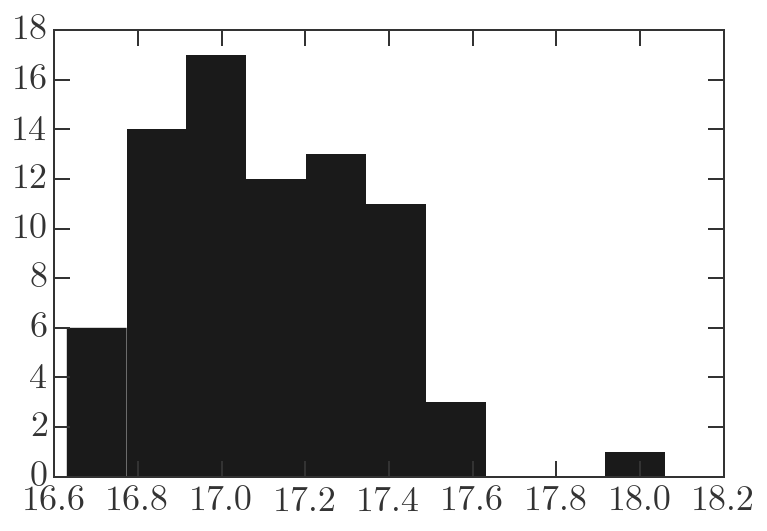

In [25]:
pl.hist(triand_tbl['VmagAvg'])

Match to old data

In [26]:
idx, sep2d, _ = triand.match_to_catalog_sky(triand2013.galactic)

In [27]:
match_ix = (sep2d < 5*u.arcsec)
match_ix.sum()

12

In [28]:
triand2013_tbl

name,vgsr,verr,ra,dec,dist
string88,float64,float64,float64,float64,float64
TriAndRRL1,-130.854874741,18.9102680868,35.804598,31.551122,32.08
TriAndRRL2,-223.048717075,16.4761224979,30.59351,33.377335,18.75
TriAndRRL5,-212.661111198,17.9929641783,22.322702,32.72186,20.67
TriAndRRL8,-104.038532334,15.2806478144,17.992175,35.466819,21.18
TriAndRRL9,-152.125630667,18.2717889517,11.491072,40.199252,18.48
TriAndRRL10,-293.239395269,20.2906901747,16.841753,32.235145,16.14
TriAndRRL11,-110.212223466,15.0471090385,9.262168,38.824378,16.8
TriAndRRL12,-7.62203550177,18.977761144,12.887871,34.28071,21.25
TriAndRRL15,-62.7011004442,19.4162836019,8.828356,36.304111,16.79


In [29]:
names = list()
old_names = list()

for i,x in enumerate(sep2d):
    names.append("TriAnd2015RR{0:d}".format(i+1))
    if x < 5*u.arcsec:
        old_names.append(triand2013_tbl[idx[i]]['name'])
    else:
        old_names.append("--")
        

triand_tbl['ID2015'] = names
triand_tbl['ID2013'] = old_names
triand_tbl

ID,ra,dec,VmagAvg,helio_dist,l,b,mjd0,amp,period,ID2015,ID2013
string160,float64,float64,float64,float64,float64,float64,float64,float64,float64,string112,string88
CSS_J000400.3+390125,1.00149,39.02388,17.37,20.35,112.950329451,-22.926791856,53708.42139,0.74,0.4911603,TriAnd2015RR1,--
CSS_J000403.3+320108,1.01394,32.01908,17.15,19.29,111.363384069,-29.7860567341,53709.40013,0.66,0.6937011,TriAnd2015RR2,TriAndRRL33
CSS_J000521.2+371636,1.33836,37.27684,17.29,19.98,112.857835162,-24.6917710285,53708.50932,0.77,0.5136286,TriAnd2015RR3,--
CSS_J000655.8+312813,1.73265,31.47039,16.64,15.04,111.925024592,-30.4483204654,53709.35278,0.93,0.4573091,TriAnd2015RR4,--
CSS_J001728.2+341629,4.36756,34.27478,16.63,15.25,114.982659089,-28.0721184826,53708.35848,0.65,0.6443345,TriAnd2015RR5,--
CSS_J001836.3+293704,4.65128,29.61785,17.11,19.18,114.449101625,-32.7125177905,53709.16928,0.55,0.6152037,TriAnd2015RR6,--
CSS_J002001.8+362129,5.00777,36.35807,17.05,18.18,115.896010544,-26.0842339474,53708.47764,0.47,0.5029073,TriAnd2015RR7,--
CSS_J002218.3+361211,5.57656,36.20331,16.88,16.78,116.380087744,-26.2975547726,53708.30043,0.63,0.6826344,TriAnd2015RR8,TriAndRRL20
CSS_J002255.3+273119,5.73066,27.52212,16.96,17.83,115.218030063,-34.9221558387,53709.58433,0.69,0.5559082,TriAnd2015RR9,--


In [30]:
# ascii.write(triand_tbl, "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015.txt")#, format="ascii")

In [31]:
# ascii.write(triand_tbl[triand_tbl['ID2013']=='--'][['ID2015','ra','dec']], "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015_short.txt")#, format="ascii")

In [32]:
triand_tbl_sex = triand_tbl.copy()

ra = coord.Longitude(triand_tbl_sex['ra']*u.deg)
triand_tbl_sex['ra_sex'] = ra.to_string(unit=u.hour, precision=5, sep=' ')

dec = coord.Latitude(triand_tbl_sex['dec']*u.deg)
triand_tbl_sex['dec_sex'] = dec.to_string(unit=u.degree, precision=5, sep=' ')

ascii.write(triand_tbl_sex[triand_tbl['ID2013']=='--'][['ID2015','ra_sex','dec_sex']], "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015_short_sexa.txt")

---

### Brightness limit of Catalina

Claim is that it is V ~ 12.5

In [21]:
from gary.observation import distance, apparent_magnitude
from gary.observation.rrlyrae import M_V

In [22]:
distance(12.5 - M_V(-1.5)).to(u.kpc)

<Quantity 2.570395782768865 kpc>

In [23]:
apparent_magnitude(M_V(-1.5), 10.*u.kpc)

15.449999999999999

---

### Exposure times

In [24]:
from scipy.interpolate import InterpolatedUnivariateSpline

(14, 18)

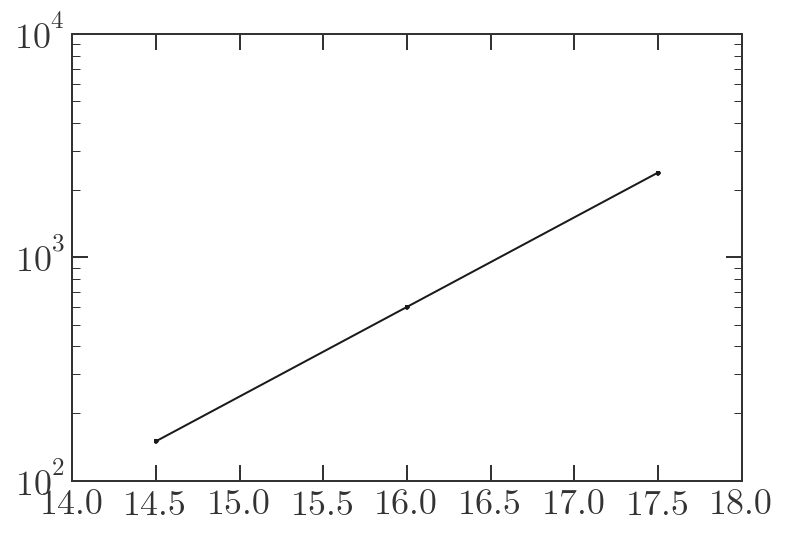

In [26]:
pl.semilogy([14.5,16,17.5], [150,600,2400])
pl.xlim(14, 18)

In [27]:
def Vmag_to_exptime(V):
    s = InterpolatedUnivariateSpline([14.5,16,17.5], np.log10([150,600,2400]), k=1)
    y = 10**s(V)
    return y

In [48]:
triand_exptimes = [Vmag_to_exptime(V) for V in triand_tbl['VmagAvg']]
GASS_exptimes = [Vmag_to_exptime(V) for V in gass_tbl['VmagAvg']]

In [49]:
len(triand_exptimes), len(GASS_exptimes)

(340, 56)

In [50]:
# print("TriAnd", (sum(triand_exptimes)*u.second).to(u.hour))
print("GASS", (sum(GASS_exptimes)*u.second).to(u.hour))

('GASS', <Quantity 16.86620178123974 h>)
